In [2]:
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from PIL import Image
from functools import partial
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import pandas as pd
import re
from collections import defaultdict
import json
import amornsaensuk as am

def up_sampling(fire_name, nml_name):
    n_fire = len(fire_name)
    n_nml = len(nml_name)
    up = np.abs(n_fire - n_nml)

    if n_fire < n_nml:
        up_time = (up//n_fire) + 1
        up_remain = up%n_fire
        fire_name = fire_name * up_time
        fire_name = fire_name + fire_name[:up_remain]
    else:
        up_time = (up//n_nml) + 1
        up_remain = up%n_nml
        nml_name = nml_name * up_time
        nml_name = nml_name + nml_name[:up_remain]

    return fire_name, nml_name

In [3]:
fname, label = am.load_fname_label('./data/Train')
fname_test, tst_label = am.load_fname_label('./data/Test')

dirname = glob.glob('./data/*')
add_fname = glob.glob(dirname[0]+'/*')
add_nm_name = []
for d in dirname[1:-2]:
    add_nm_name.extend(glob.glob(d + '/*'))


size = (150,150)
fname_val = fname[:100]
fname_val.extend(fname[-100:])
fname_val.extend(add_fname[:10])
fname_val.extend(add_nm_name[:50])
fname_test_add = (add_fname[10:20])
fname_test_add.extend(add_nm_name[50:100])
fname_train = fname[100:-100]
fname_train.extend(add_fname[20:])
fname_train.extend(add_nm_name[100:])



In [4]:
fire = []
nml = []
for name in fname_train:
    if re.search('Fire',name):
        fire.append(name)
    else:
        nml.append(name)

In [5]:
fire, nml = up_sampling(fire,nml)

fname_train = fire + nml

In [6]:
x_t, y_t = am.load_xy(fname_train,size)
x_v, y_v = am.load_xy(fname_val,size)
x_tst,y_tst = am.load_xy(fname_test,size)
x_tst_add,y_tst_add = am.load_xy(fname_test_add,size)

creating x,y: 100%|██████████| 60/60 [00:00<00:00, 64.54it/s]


In [7]:
datagen_train = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')

datagen_val = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
datagen_test = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')
datagen_test_add = ImageDataGenerator(rotation_range=90,
                            width_shift_range=0.3,
                            height_shift_range=0.4,
                            horizontal_flip=True,
                            vertical_flip=True,
                            fill_mode='nearest')


In [8]:

X_val = []
y_val = []
datagen_train.fit(x_t)
datagen_val.fit(x_v)
datagen_test.fit(x_tst)
datagen_test_add.fit(x_tst_add)
X_train, y_train = am.augment_data(x_t,y_t,datagen_train,6000)
X_val, y_val = am.augment_data(x_v,y_v, datagen_val, 600)
X_test, y_test = am.augment_data(x_tst,y_tst, datagen_val, 600)
X_test_add, y_test_add = am.augment_data(x_tst_add,y_tst_add, datagen_val, 600)

data augmenting:: 6016it [00:22, 269.57it/s]                          
data augmenting:: 640it [00:02, 272.96it/s]                         
data augmenting:: 672it [00:02, 283.06it/s]                         
data augmenting:: 640it [00:02, 281.89it/s]                         


## CNN

In [9]:

model = Sequential()
model.add(Conv2D(64, 3, padding="same", activation="relu", input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, 5,strides=(2,2), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2, 2)))


model.add(Flatten())
model.add(Dropout(0.4))

model.add(Dense(256,activation="relu",activity_regularizer=l2(10e-2)))
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 19, 19, 128)       204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 10368)             0

In [10]:
save_name = 'last_cnn_1'

early_stopping = EarlyStopping(monitor='val_loss',
                              patience=20,
                              verbose=0,
                              mode='auto')
model_save = ModelCheckpoint('./models/'+ save_name+'.hdf5',
                             save_best_only=True,
                             monitor='val_loss',
                             mode='min',
                            verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=5,
                              verbose=1,
                              min_delta=1e-4,
                              mode='min')
tb = TensorBoard(log_dir='./logsCloud/'+save_name)

In [11]:
model.compile(loss='binary_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

train_log_cnn = model.fit(X_train,y_train,
                          batch_size=128,
                          epochs=100,
                          validation_data=(X_val, y_val),
                         callbacks=[early_stopping, model_save, reduce_lr])

Epoch 1/100
48/48 [==============================] - 142s 3s/step - loss: 0.6580 - accuracy: 0.6748 - val_loss: 0.5469 - val_accuracy: 0.8247

Epoch 00001: val_loss improved from inf to 0.54686, saving model to ./models/last_cnn_1.hdf5
Epoch 2/100
48/48 [==============================] - 140s 3s/step - loss: 0.5552 - accuracy: 0.7990 - val_loss: 0.5923 - val_accuracy: 0.7045

Epoch 00002: val_loss did not improve from 0.54686
Epoch 3/100
48/48 [==============================] - 140s 3s/step - loss: 0.4785 - accuracy: 0.8403 - val_loss: 0.3793 - val_accuracy: 0.9026

Epoch 00003: val_loss improved from 0.54686 to 0.37928, saving model to ./models/last_cnn_1.hdf5
Epoch 4/100
48/48 [==============================] - 139s 3s/step - loss: 0.3785 - accuracy: 0.9098 - val_loss: 0.4046 - val_accuracy: 0.8588

Epoch 00004: val_loss did not improve from 0.37928
Epoch 5/100
48/48 [==============================] - 139s 3s/step - loss: 0.3425 - accuracy: 0.9118 - val_loss: 0.3275 - val_accuracy: 0

In [18]:
model.save('last_cnn_manualsave.hdf5')
hist = train_log_cnn.history
del hist['lr']
with open(save_name+'_log.json', 'w') as f:
    json.dump(hist, f)

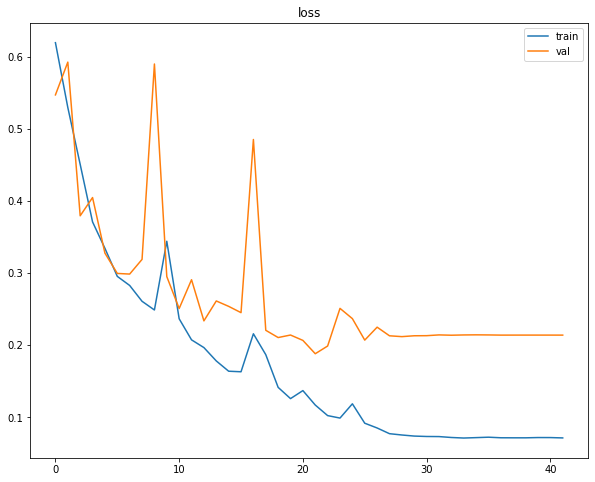

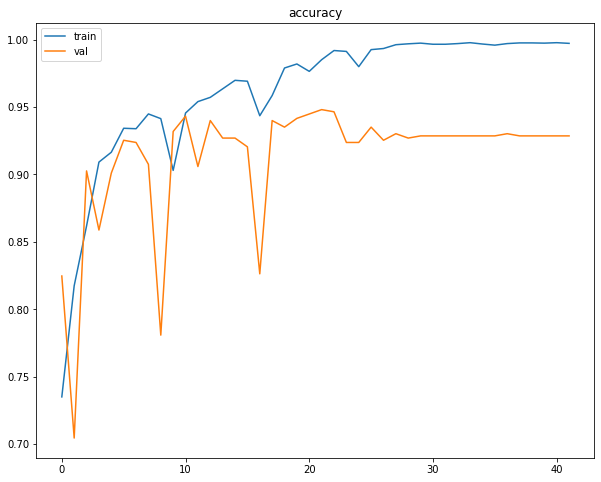

In [19]:
am.plot_train_log(train_log_cnn.history)

In [44]:
prediction = model.predict(X_test)
prediction = [1 if x >=0.5 else 0 for x in prediction]

am.model_eval(prediction,y_test)

	Confusion Matrix
------------------------------
	   Predict
            "1" |  "0"
Actual "1"| 308 | 11
       "0"| 40  | 273
------------------------------

accuracy =  0.9193037974683544
precision =  0.8850574712643678
recall =  0.9655172413793104
F1 =  0.9235382308845578


(308, 40, 11, 273)

In [29]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 3s 128ms/step - loss: 0.3036 - accuracy: 0.9051


[0.3035998046398163, 0.905063271522522]

In [46]:
prediction = model.predict(X_test_add)
prediction = [1 if x >=0.5 else 0 for x in prediction]

am.model_eval(prediction,y_test_add)

	Confusion Matrix
------------------------------
	   Predict
            "1" |  "0"
Actual "1"| 103 | 3
       "0"| 46  | 480
------------------------------

accuracy =  0.9224683544303798
precision =  0.6912751677852349
recall =  0.9716981132075472
F1 =  0.807843137254902


(103, 46, 3, 480)